In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

from pendulum_ml.models.registry import make_model
from pendulum_ml.data.dataset import build_loaders
from pendulum_ml.verification.attacks import make_attack_fn
from pendulum_ml.verification import xai
from pendulum_ml.utils import parse_with_config, import_system

# run_clean = "quad_clean_config"
# run_adv = "quad_adv_config"
run_clean = "clean_model-20251026-214014"
run_adv = "adv_model"
base_path = Path("../experiments")
model_path= Path("../models/checkpoints")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


/Users/julialg2002/miniforge3/envs/pendulum-ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(run_id):
    run_dir = base_path / run_id
    cfg = json.loads((run_dir / "config.json").read_text())
    model = make_model(cfg["model"]["name"],
                       in_dim=cfg["model"]["in_dim"],
                       hidden=tuple(cfg["model"]["hidden"]),
                       out_dim=cfg["model"]["out_dim"]).to(device)
    ckpt = model_path / f"{run_id}.pt"
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()
    return model, cfg

model_clean, cfg_clean = load_model(run_clean)
model_adv, cfg_adv = load_model(run_adv)
print(cfg_clean)


{'seed': 42, 'device': 'cpu', 'system': 'quadcopter', 'dynamics': {'dt': 0.01, 'control_dt': 0.01, 'integrator': 'rk4', 'params': {'quad': {'mass': 1.5, 'inertia': 0.03, 'arm_length': 0.25}, 'payload': {'mass': 0.25, 'rope_length': 1.0}, 'environment': {'gravity': 9.81}, 'winch': {'model': 'algebraic', 'omega': 10.0}, 'actuators': {'max_thrust': 20.0, 'max_pitch_torque': 5.0, 'min_pitch_torque': -5.0}}}, 'controller': {'type': 'pid', 'pid': {'x': {'Kp': 8, 'Ki': 0, 'Kd': 12, 'u_min': -10.0, 'u_max': 10.0, 'setpoint': 4.0}, 'z': {'Kp': 40.0, 'Ki': 5, 'Kd': 10, 'u_min': -10.0, 'u_max': 10.0, 'setpoint': 5.0}, 'theta': {'Kp': 30, 'Ki': 0, 'Kd': 4, 'u_min': -5.0, 'u_max': 5.0, 'setpoint': 0.0}, 'phi': {'Kp': 30.0, 'Ki': 0, 'Kd': 4.0, 'u_min': -10.0, 'u_max': 10.0}, 'l': {'Kp': 0.0, 'Ki': 0.0, 'Kd': 0.0, 'u_min': 0.0, 'u_max': 0.0}}}, 'data': {'n_trajectories': 9, 'initial_state': [[0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [2.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [-2.0,

In [3]:
attack_fn = make_attack_fn(method="pgd", eps=0.1, steps=40, alpha=0.0025)
loaders = build_loaders(cfg_clean)
X_test, Y_test = next(iter(loaders["test"]))
X_test, Y_test = X_test.to(device), Y_test.to(device)

x = X_test[0:1]
y = Y_test[0:1]

x_adv = attack_fn(model_clean, x, y)

with torch.no_grad():
    clean_pred = model_clean(x)
    adv_pred = model_clean(x_adv)
    robust_pred = model_adv(x_adv)

print("Clean model (clean input):", clean_pred)
print("Clean model (adv input):", adv_pred)
print("Adv-trained model (adv input):", robust_pred)


Clean model (clean input): tensor([[-6.9144e-04,  1.5963e+00, -7.6876e-04,  2.6485e-04,  1.0323e-03]],
       device='mps:0')
Clean model (adv input): tensor([[-2.1601e-01,  1.6079e+00,  1.3297e-02,  6.2462e-02,  3.2249e-05]],
       device='mps:0')
Adv-trained model (adv input): tensor([[-8.4932e-03,  1.5959e+00,  9.8901e-03, -9.4627e-04,  8.3434e-04]],
       device='mps:0')


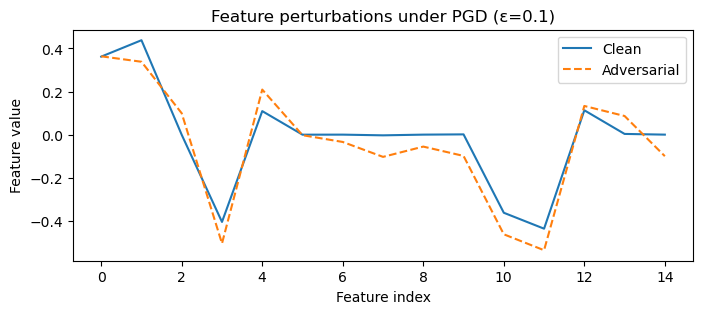

In [4]:
attack_fn = make_attack_fn(method="pgd", eps=0.1, steps=40)

x = X_test[0:1]
y = Y_test[0:1]
x_adv = attack_fn(model_clean, x, y)

plt.figure(figsize=(8,3))
plt.plot(x.cpu().numpy().flatten(), label="Clean")
plt.plot(x_adv.cpu().numpy().flatten(), "--", label="Adversarial")
plt.title("Feature perturbations under PGD (ε=0.1)")
plt.xlabel("Feature index")
plt.ylabel("Feature value")
plt.legend()
plt.show()


In [5]:
def evaluate(model, X, Y, attack_fn):
    with torch.no_grad():
        clean_loss = torch.nn.functional.mse_loss(model(X), Y).item()
    X_adv = attack_fn(model, X, Y)
    with torch.no_grad():
        adv_loss = torch.nn.functional.mse_loss(model(X_adv), Y).item()
    return clean_loss, adv_loss

epsilons = [0.01, 0.05, 0.08, 0.1, 0.2]
steps = [5, 10, 20, 40, 50]
results = []

for eps in epsilons:
    for s in steps:
        attack = make_attack_fn("pgd", eps=eps, steps=s, alpha=eps/s)
        loss_clean, loss_adv_clean = evaluate(model_clean, X_test, Y_test, attack)
        loss_clean_adv, loss_adv_adv = evaluate(model_adv, X_test, Y_test, attack)
        results.append((eps, s, loss_clean, loss_adv_clean, loss_clean_adv, loss_adv_adv))

import pandas as pd
df = pd.DataFrame(results, columns=["eps", "steps", "clean_loss", "adv_loss_clean", "clean_loss_adv","adv_loss_adv"])
df


,eps,steps,clean_loss,adv_loss_clean,clean_loss_adv,adv_loss_adv
0,0.01,5,0.00296,0.003439,0.002308,0.002689
1,0.01,10,0.00296,0.003403,0.002308,0.002725
2,0.01,20,0.00296,0.003419,0.002308,0.002740
3,0.01,40,0.00296,0.003432,0.002308,0.002664
4,0.01,50,0.00296,0.003474,0.002308,0.002702
5,0.05,5,0.00296,0.011263,0.002308,0.005767
6,0.05,10,0.00296,0.011192,0.002308,0.005257
7,0.05,20,0.00296,0.011576,0.002308,0.005932
8,0.05,40,0.00296,0.011346,0.002308,0.005752
9,0.05,50,0.00296,0.011423,0.002308,0.005496


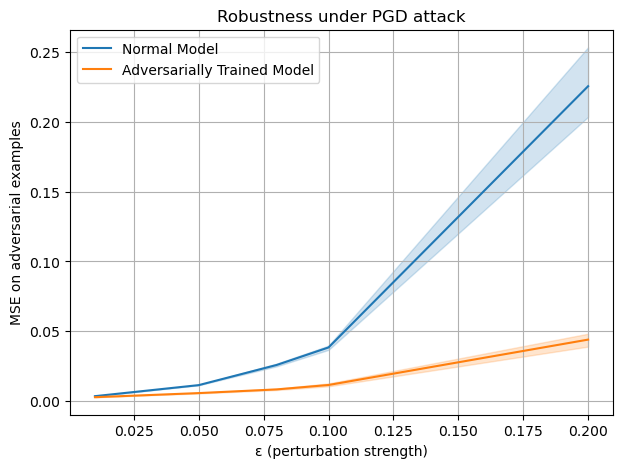

In [6]:
import seaborn as sns
plt.figure(figsize=(7,5))
sns.lineplot(data=df, x="eps", y="adv_loss_clean", label="Normal Model")
sns.lineplot(data=df, x="eps", y="adv_loss_adv", label="Adversarially Trained Model")
plt.title("Robustness under PGD attack")
plt.xlabel("ε (perturbation strength)")
plt.ylabel("MSE on adversarial examples")
plt.legend()
plt.grid(True)
plt.show()


['x', 'z', 'theta', 'xq_dot', 'zq_dot', 'theta_dot', 'l', 'phi', 'l_dot', 'phi_dot', 'error_x', 'error_z', 'error_theta', 'error_phi', 'error_l']


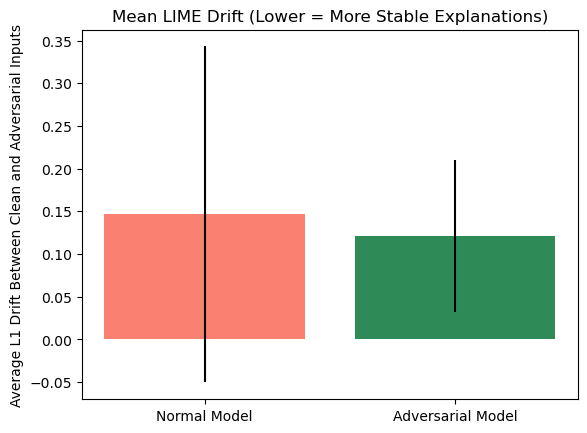

LIME Drift — Normal: 0.1463 ± 0.1967 | Adversarial: 0.1213 ± 0.0889


In [7]:
import numpy as np
import matplotlib.pyplot as plt


cps = import_system(cfg_clean["system"])
feature_names = cps.STATE_NAMES + [f"error_{axis}" for axis in cps.CONTROL_AXES]
print(feature_names)

# Create wrapper models that work on CPU for LIME
class CPUModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def __call__(self, x):
        # x is numpy array from LIME, convert to tensor and move to device
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32).to(self.device)
        elif x.device != self.device:
            x = x.to(self.device)
        
        with torch.no_grad():
            return self.model(x)

model_clean_cpu = CPUModelWrapper(model_clean, device)
model_adv_cpu = CPUModelWrapper(model_adv, device)

# Collect LIME drifts for multiple test samples - ensure CPU data for LIME
explainer = xai.explain_lime(model_clean_cpu, X_test[:100].cpu(), feature_names)
explainer_adv = xai.explain_lime(model_adv_cpu, X_test[:100].cpu(), feature_names)

def avg_drift(model_wrapper, explainer, X, attack_fn, n_samples=30):
    drifts = []
    for i in np.random.choice(len(X), n_samples, replace=False):
        x = X[i:i+1]
        y = model_wrapper.model(x)  # Use the original model for attack
        x_adv = attack_fn(model_wrapper.model, x, y)
        # Convert to CPU tensors for LIME
        exp_clean = xai.lime_explain_instance(model_wrapper, explainer, x[0].cpu(), output_idx=0)
        exp_adv = xai.lime_explain_instance(model_wrapper, explainer, x_adv[0].cpu(), output_idx=0)
        drifts.append(xai.attribution_drift(exp_clean, exp_adv))
    return np.mean(drifts), np.std(drifts)

mean_clean, std_clean = avg_drift(model_clean_cpu, explainer, X_test, make_attack_fn("pgd", eps=0.1, steps=40))
mean_adv, std_adv = avg_drift(model_adv_cpu, explainer_adv, X_test, make_attack_fn("pgd", eps=0.1, steps=40))

plt.bar(["Normal Model", "Adversarial Model"], [mean_clean, mean_adv], yerr=[std_clean, std_adv], color=["salmon","seagreen"])
plt.title("Mean LIME Drift (Lower = More Stable Explanations)")
plt.ylabel("Average L1 Drift Between Clean and Adversarial Inputs")
plt.show()

print(f"LIME Drift — Normal: {mean_clean:.4f} ± {std_clean:.4f} | Adversarial: {mean_adv:.4f} ± {std_adv:.4f}")

LIME Drift: 0.0447
Feature names length: 15
Feature names: ['x', 'z', 'theta', 'xq_dot', 'zq_dot', 'theta_dot', 'l', 'phi', 'l_dot', 'phi_dot', 'error_x', 'error_z', 'error_theta', 'error_phi', 'error_l']
x shape: torch.Size([1, 15])
vals_clean shape: (15,)
vals_adv shape: (15,)
Using 15 features for plotting


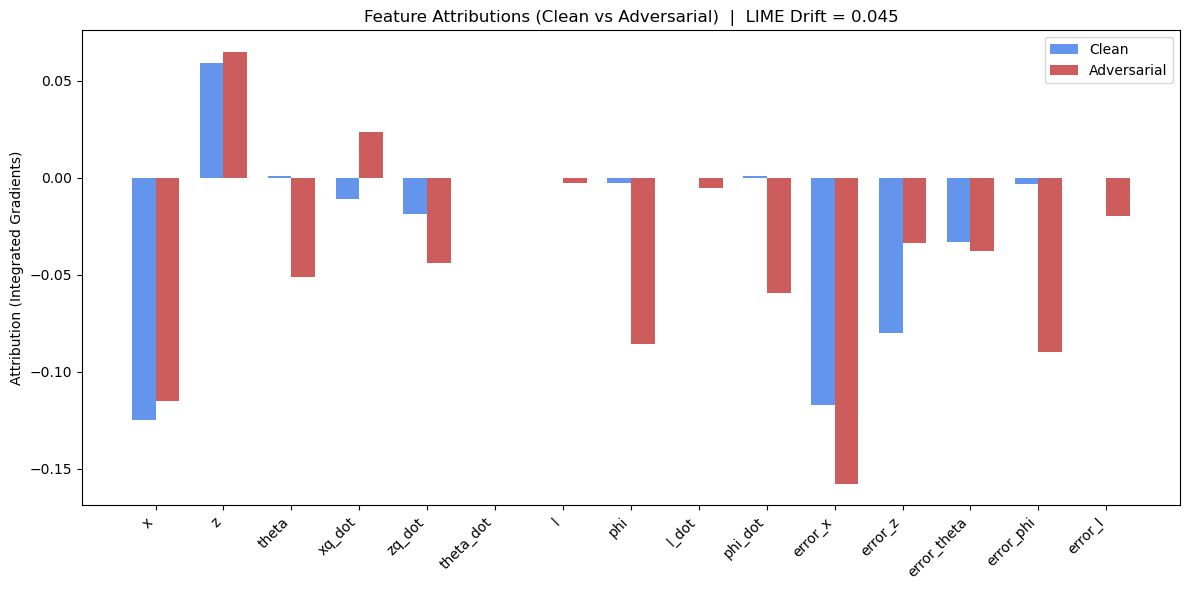

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# --- LIME drift computation ---
explainer = xai.explain_lime(model_clean_cpu, X_test[:100].cpu(), feature_names)
exp_clean = xai.lime_explain_instance(model_clean_cpu, explainer, x[0].cpu(), output_idx=0)
exp_adv   = xai.lime_explain_instance(model_clean_cpu, explainer, x_adv[0].cpu(), output_idx=0)
drift = xai.attribution_drift(exp_clean, exp_adv)
print(f"LIME Drift: {drift:.4f}")

# --- Integrated Gradients for both clean & adv ---
# Move model to CPU temporarily for integrated gradients (to avoid MPS float64 issues)
model_clean_cpu_temp = model_clean.cpu()
x_cpu = x.cpu()
x_adv_cpu = x_adv.cpu()

attrs_clean, _ = xai.integrated_gradients(model_clean_cpu_temp, x_cpu, target=0)
attrs_adv, _   = xai.integrated_gradients(model_clean_cpu_temp, x_adv_cpu, target=0)

# Move model back to original device
model_clean.to(device)

vals_clean = attrs_clean.cpu().numpy().flatten()
vals_adv   = attrs_adv.cpu().numpy().flatten()

# Debug: check shapes
print(f"Feature names length: {len(feature_names)}")
print(f"Feature names: {feature_names}")
print(f"x shape: {x.shape}")
print(f"vals_clean shape: {vals_clean.shape}")
print(f"vals_adv shape: {vals_adv.shape}")

# The model might have been trained on a different input size than our feature names
# Use only the first len(feature_names) attributions
n_features = min(len(feature_names), len(vals_clean))
feature_names_plot = feature_names[:n_features]
vals_clean_plot = vals_clean[:n_features]
vals_adv_plot = vals_adv[:n_features]

print(f"Using {n_features} features for plotting")

# --- Combined bar chart ---
x_idx = np.arange(n_features)
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x_idx - width/2, vals_clean_plot, width, label="Clean", color="cornflowerblue")
plt.bar(x_idx + width/2, vals_adv_plot, width, label="Adversarial", color="indianred")

plt.xticks(x_idx, feature_names_plot, rotation=45, ha="right")
plt.ylabel("Attribution (Integrated Gradients)")
plt.title(f"Feature Attributions (Clean vs Adversarial)  |  LIME Drift = {drift:.3f}")
plt.legend()
plt.tight_layout()
plt.show()